# Procedure for an indirect test of the time-drift effect:
1. Use Sloan Digital Sky Survey (SDSS) SQL Queries to select galaxies within a redshift (z) range 0.15 < z < 0.3. This range is chosen from Morseco (2011), *"Early-type galaxies as probes of galaxy formation and cosmology,"* for its S/N strength using the $D4000_n$ parameter.

2. Collect and label spectrum and feature data for each galaxy. Spectrum data can then be used to:

    * Make data quality cuts based on error values.

    * Characterize galaxy class.

    * Determine if the galaxy has an active galactic nuclei (AGN).

3. Determine the galaxy's morphology. This is used as a control variable to prevent mixing data from populations that evolve differently regardless of environment.

4. Determine the galaxy's local population density within a range of volumes.

5. Create different plots of data with population density as the independent variable (x-axis) and $D4000_n$ and $H\delta$ as the dependent variables. Split plots by environment (local population density: void/underdense, filament/field, wall/cluster) for different morphologies and SFHs.
6. Investigate **systematic offsets/divergences** between environment classes.

# 1. SQL Query
This step is handled using two separate queries and results in two final CSV files with different data. The Galaxy Zoo project only has morphology estimates for 27109 galaxies in the given redshift range, while the total SDSS sample for the same range includes 324048 galaxies. To avoid timeout errors in either sample, two functions were created using the arguments of a chunk size (number of galaxies to select), the objid of the last object in the previous list (0 can be chosen for the initial value), and a general filename to query SDSS before creating a CSV file of the given chunk size number of galaxies. The two functions differ only in their query text. The generated files are named iteratively using the filename argument and the final objid in the generated table. This objid is also returned as a value to be used in a looping function. 

A second function then loops this function using the final objid until there are no galaxies left. After exhausting the pool of galaxies, this function then combines all the previous CSV files into a single larger one to simplify future function calls.

The exact RA, DEC, z, zerr, plate, mjd, and fiberid can all be collected from the FITS file, as well as the spectral data required for analysis.

This query can then return a CSV file which has as one of its columns a link to a downloadable FITS file. These files can then be downloaded and put into another file as:

In [32]:
import pandas as pd
import requests
from pathlib import Path
from astroquery.sdss import SDSS
import time

def sdss_chunk_query(chunk_size, last_id, file_name, folder_name):
    """
    SQL search SDSS database to return a csv file with the objid, plate, mjd, fiberid,
    and FITS file URL for all galaxies between z=0.13 to z=0.3, 50000 galaxies at a time
    to prevent timeout.
    """
    sdss_chunk = f"""
SELECT TOP {chunk_size}
p.objid, s.plate, s.mjd, s.fiberid, s.z, p.ra, p.dec,
dbo.fGetUrlFitsSpectrum(s.specObjID) AS spec_fits_url
FROM PhotoObj AS p
JOIN SpecObj AS s
    ON p.objid = s.bestobjid
JOIN Galaxy AS g
    ON g.objid = p.objid
    WHERE s.class = 'GALAXY'
    AND s.z BETWEEN 0.1397816562350196 AND 0.311104966694253
    AND s.zWarning = 0
    AND p.objid > {last_id}
ORDER BY p.objid
    """
    table = SDSS.query_sql(sdss_chunk)
    if table is None:
        return None, None
    last_id = table[-1][0]
    new_file_name = f'{file_name}{last_id}.csv'
    table.write(f"{folder_name}/{new_file_name}", format="csv", overwrite=True)
    return last_id, new_file_name

def galaxy_zoo_chunk_query(chunk_size, last_id, file_name, folder_name):
    """
    SQL search SDSS database to return a csv file with the confidence rating for
    if a galaxy is elliptical, clockwise spiral, anticlockwise spiral, edgeon,
    unknown, or merger for every shared SDSS & Galaxy Zoo object between z=0.15 to z=0.3
    """
    galaxy_zoo_chunk = f"""
SELECT TOP {chunk_size}
p.objid,
zns.p_el as elliptical,
zns.p_cw as spiralclock,
zns.p_acw as spiralanticlock,
zns.p_edge as edgeon,
zns.p_dk as dontknow,
zns.p_mg as merger
FROM PhotoObj AS p
JOIN SpecObj AS s
    ON p.objid = s.bestobjid
JOIN Galaxy AS g
    ON g.objid = p.objid
JOIN ZooNoSpec AS zns
    ON zns.objid = g.objid
WHERE 
    s.class = 'GALAXY'
    AND s.z BETWEEN 0.15 AND 0.3
    AND s.zWarning = 0
    AND p.objid > {last_id}
ORDER BY p.objid
    """
    table = SDSS.query_sql(galaxy_zoo_chunk)
    if table is None:
        return None, None
    last_id = table[-1][0]
    new_file_name = f'{file_name}{last_id}.csv'
    table.write(f"{folder_name}/{new_file_name}", format="csv", overwrite=True)
    return last_id, new_file_name

def merge_csv(files, final_file, final_folder):
    """
    Take a list of CSV files and combine them into a single file.
    """
    outdir = Path(final_folder)
    outdir.mkdir(parents=True, exist_ok=True)
    df_list = [pd.read_csv(f) for f in files]
    combined = pd.concat(df_list, ignore_index=True)
    combined.to_csv(f"{outdir}/{final_file}", index=False)
    return combined

def cleanup_files(files):
    """
    Deletes a list files, helping to conserve memory.
    """
    for f in files:
        Path(f).unlink(missing_ok=True)

def loop_galaxy_chunk(query, chunk_size, last_id, file_name, final_file, folder_name):
    csv_file_list = []
    outdir = Path(folder_name)
    outdir.mkdir(parents=True, exist_ok=True)

    while True:
        retries = 0

        while retries <= 5:
            try:
                print(f'Collecting next {chunk_size} galaxies for {folder_name}...')
                last_id, new_file_name = query(chunk_size, last_id, file_name, folder_name)

                if last_id is None:
                    break  # exhausted — exit retry loop

                print(f'Creating builder file: {new_file_name}')
                csv_file_list.append(str(outdir / new_file_name))
                break

            except Exception as e:
                retries += 1
                if retries > 5:
                    raise
                time.sleep(3)

        if last_id is None:
            break  # exhausted — exit outer loop

    print(f'Merging {len(csv_file_list)} CSV files for {folder_name}...')
    merge_csv(csv_file_list, final_file, folder_name)
    cleanup_files(csv_file_list)
    print("Done!")

#loop_galaxy_chunk(galaxy_zoo_chunk_query, 10000, 0, "galaxy_zoo_morphology_", "full_morphology.csv", "ZOO")
#loop_galaxy_chunk(sdss_chunk_query, 10000, 0, "sdss_db_", "full_sdss.csv", "SDSS")

def download_fits_chunk(source_csv_file, start, end, outdir):
    """
    Uses final SDSS CSV file to fill a FITS folder with the 
    downloaded FITS files of all available galaxies in the desired redshift range (0.15-0.3).
    """
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(source_csv_file, header=0)

    for i in range(start, end):
        row = df.iloc[i]
        if 0.15 <= row['z'] <= 0.3:
        
            plate = row["plate"]
            mjd   = row["mjd"]
            fiber = row["fiberid"]
            url   = row["spec_fits_url"]

            filename = f'spec-{plate:04d}-{mjd}-{fiber:04d}.fits'
            filepath = outdir / filename

            # Handle non-existing FITS files:
            if not isinstance(url, str) or not url.strip():
                print(f"No valid url for {filename}, skipping.")
                continue

            if filepath.exists():
                continue

            r = requests.get(url, stream=True)
            r.raise_for_status()

            with open(filepath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

download_fits_chunk("SDSS/full_sdss.csv", 0, 50, outdir="FITS Test 2")

Extracting from the returned FITS file (spec_fits_url) and converting to rest wavelength using $\lambda_{rest} = \frac{\lambda_{obs}}{(1 + z)}$:

1. Break strength at 4000 $\AA$. Flux from 4000-4100 $\AA$, $F_{red}$ and 3850-3950 $\AA$, $F_{blue}$. $$D4000_n = \frac{F_{red}}{F_{blue}}$$ This value must be calculated from the data.

2. The uncertainty in $D4000_n$, found using the inverse variance of the same flux ranges as $$\sigma(D4000_n)=D4000_n \times \sqrt{(\frac{\sigma F_{red}}{F_{red}})^2 + (\frac{\sigma F_{blue}}{F_{blue}})^2}$$ This value must be calculated from the data.

3. The flux produced by singly-ionized oxygen at a wavelength of 3727 $\AA$, denoted $[O \text{ } _{II}]\lambda3727$.

4. The rest frame equivalent width of this line ($W_0[O \text{ } _{II}]$).

5. The flux of the $H\delta$ Balmer line at 4101 $\AA$.

6. The rest frame equivalent width of this line ($W_0[H\delta]$).

# 2. Collect and label spectrum data for each galaxy
The collect_spectrum_data function is designed to extract the above data from a single FITS file, returning a dictionary of the related values.

In [9]:
from astropy.io import fits
import numpy as np
# Extract data

def collect_spectrum_data(file):
    """
    Compute D4000n, collect [OII] 3727 & Hdelta flux/EW from a single SDSS FITS spectrum file.

    Negative Err values = invalid fit.

    Flux is negative for absorption spectra, positive for emission.
    """
    # Open file
    hdul = fits.open(file)
    
    # Assign dfs
    hdu     = hdul[0].header
    coadd   = hdul[1].data
    specobj = hdul[2].data
    spzline = hdul[3].data

    # Info
    ra  = hdu['PLUG_RA']
    dec = hdu['PLUG_DEC']

    # Label data
    plate = spzline['PLATE'][0]
    mjd   = spzline['MJD'][0]
    fiber = spzline['FIBERID'][0]
    fileid = f'spec-{plate}-{mjd}-{fiber:04d}'
    try:
        objid = specobj['bestObjID'][0]
    except Exception as e:
        #print(f'Error on {fileid}: {e}')
        #print(f'Trying new key...')
        try:
            objid = specobj['OBJID'][0]
            #print('Success!')
        except Exception as e:
            #print(f'Failed again on {objid}: {e}')
            #print(f'Skipping object...')
            objid = None

    # Flux and wavelength
    flux       = coadd['flux']
    loglam     = coadd['loglam']
    lambda_obs = 10**loglam
    ivar       = coadd['ivar']

    # Redshift
    z     = specobj['Z'][0]
    z_err = specobj['Z_ERR'][0]

    # Shift to rest-frame
    lambda_rest = lambda_obs / (1 + z)

    # Find D4000n and uncertainty
    red_mask     = (lambda_rest >= 4000) & (lambda_rest <= 4100)
    blue_mask    = (lambda_rest >= 3850) & (lambda_rest <= 3950)
   
    F_red        = np.mean(flux[red_mask])
    red_ivar     = ivar[red_mask]

    F_blue       = np.mean(flux[blue_mask])
    blue_ivar    = ivar[blue_mask]

    D4000n       = F_red / F_blue

    # Protect against divisions by zero
    good_red = red_ivar > 0
    good_blue = blue_ivar > 0
    if good_red.sum() == 0 or good_blue.sum() == 0:
        sigma_D4000n = np.inf
    else:    
        sigma_red    = np.sqrt(1 / np.sum(red_ivar[good_red]))
        sigma_blue   = np.sqrt(1 / np.sum(blue_ivar[good_blue]))
        sigma_D4000n = D4000n * np.sqrt(
        (sigma_red / F_red)**2 +
        (sigma_blue / F_blue)**2
    )
    

    # OII 3727 Flux and EW
    oii_mask     = spzline['LINENAME']=='[O_II] 3727'
    oii_flux     = spzline['LINEAREA'][oii_mask][0]
    oii_flux_err = spzline['LINEAREA_ERR'][oii_mask][0]
    oii_EW       = spzline['LINEEW'][oii_mask][0]
    oii_EW_err   = spzline['LINEEW_ERR'][oii_mask][0]

    # H delta Flux and EW
    h_delta_mask     = spzline['LINENAME']=='H_delta'
    h_delta_flux     = spzline['LINEAREA'][h_delta_mask][0]
    h_delta_flux_err = spzline['LINEAREA_ERR'][h_delta_mask][0]
    h_delta_EW       = spzline['LINEEW'][h_delta_mask][0]
    h_delta_EW_err   = spzline['LINEEW_ERR'][h_delta_mask][0]

    # Other lines for AGN
    # OIII 5007, H beta, NII 6583, H alpha
    o_iii_mask   = spzline['LINENAME']=='[O_III] 5007'
    o_iii_flux   = spzline['LINEAREA'][o_iii_mask][0]
    h_beta_mask  = spzline['LINENAME']=='H_beta'
    h_beta_flux  = spzline['LINEAREA'][h_beta_mask][0]
    n_ii_mask    = spzline['LINENAME']=='[N_II] 6583'
    n_ii_flux    = spzline['LINEAREA'][n_ii_mask][0]
    h_alpha_mask = spzline['LINENAME']=='H_alpha'
    h_alpha_flux = spzline['LINEAREA'][h_alpha_mask][0]


    # Creating dictionary to store values
    spectrum_data_dict = {
        'objid': objid,
        'fileid': fileid,  
        'ra': ra,
        'dec': dec,                     
        'z': z,                                
        'z_err': z_err,                       
        'D4000n': D4000n, 
        'sigma_D4000n': sigma_D4000n,                    
        'oii_flux': oii_flux,                 
        'oii_flux_err': oii_flux_err,         
        'oii_EW': oii_EW,                     
        'oii_EW_err': oii_EW_err,             
        'h_delta_flux': h_delta_flux,         
        'h_delta_flux_err': h_delta_flux_err, 
        'h_delta_EW': h_delta_EW,             
        'h_delta_EW_err': h_delta_EW_err,
        'o_iii_flux': o_iii_flux,
        'h_beta_flux': h_beta_flux,
        'n_ii_flux': n_ii_flux,
        'h_alpha_flux': h_alpha_flux,    

    }

    # Return dictionary
    return spectrum_data_dict

spectrum_data_dict = collect_spectrum_data('.\FITS\spec-417-51821-0029.fits')
for label, value in spectrum_data_dict.items():
    print(f"{label}: {value}")
    

objid: 1237649919499960551
fileid: spec-417-51821-0029
ra: 8.8299556
dec: 14.606655
z: 0.2805825173854828
z_err: 6.553764978889376e-05
D4000n: 1.890565037727356
sigma_D4000n: 0.08590532839298248
oii_flux: -9.098548889160156
oii_flux_err: 15.352132797241211
oii_EW: -5.353498935699463
oii_EW_err: 9.503395080566406
h_delta_flux: -8.447121620178223
h_delta_flux_err: 3.8982081413269043
h_delta_EW: -2.545832395553589
h_delta_EW_err: 1.2686667442321777
o_iii_flux: 4.91396951675415
h_beta_flux: 13.103048324584961
n_ii_flux: 7.335936546325684
h_alpha_flux: 6.116133213043213


# 2.1 Data quality cuts, galaxy classification.

As discussed previously, data quality cuts will be made at $\sigma(W_0[H\delta]) \ge 0.8 \text{ }\AA$. The data quality cut intended at $\sigma(D4000_n) \ge 0.03$ has proved overly restrictive for this redshift range, so another quality cut will be made based on a signal to noise (S/N) ratio of $\frac{D4000_n}{\sigma(D4000_n)}>5$. $D4000_n$ must also be positive in both bands, so negative values will be labelled as invalid. Equivalent widths (EWs) are used for S/N ratios for $W_0[H\delta]$ and $W_0[O\text{ }II]$. Detections for these bands are defined as $|EW|/EW_{err} \ge 2$, otherwise the line will be considered "Absent."

For characterizing SFH:

* $D4000_n$ tracks long-term, light-weighted (meaning weighted by how much light the stellar population contributes to the spectrum as opposed to mass-weighted) stellar age. Larger values $\to$ older.

* $W_0[H\delta]$ is sensitive to **recent changes** (~0.1-1 Gyr) in star formation. Stronger absorption $\to$ formation stopped or declined more recently.

* $W_0[O \text{ }_{II}]$ relates to recent star formation ($\le 10-50$ Myr).

Following Poggianti et al. (1999), *"The star formation histories of galaxies in distant clusters,"* the EWs can be used to classify the galaxies. The table from Poggianti et al. goes as:

| Class | $W_0[O\text{ }_{II}] \lambda 3727$ ($\AA$) | $W_0[H\delta]$ ($\AA$) | Comments                                                    |
| ---   | :---:                                      | :---:                  | ---                                                         |
|k      |Absent                                      |<3                      |Passive                                                      |
|k+a    |Absent                                      |3-8                     |Moderate Balmer absorption without emission                  |
|a+k    |Absent                                      |$\ge 8$                 |Strong Balmer absorption without emission                    |
|e(c)   |Yes, $\lt 40$                               |$\lt 4$                 |Moderate Balmer absorption plus emission, spiral-like        |
|e(a)   |Yes                                         |$\ge 4$                 |Strong Balmer absorption plus emission                       |
|e(b)   |$\ge 40$                                    |...                     |Starburst                                                    |
|e(n)   |...                                         |...                     |AGN from broad lines or $[O\text{ }_{II}] 5007/H\beta$ ratio |
|e      |Yes                                         |?                       |At least one emission line, but S/N too low to classify      |
|?      |?                                           |?                       |Unclassifiable                                               |

"Absent" here is classified as an EW stronger than -5 $\AA$ (meaning <-5). The "..." entries indicate that the specific spectral index is not used to define the galaxy class. For Active Galactic Nuclei (AGN) objects, as both EWs for [O II] and $H\delta$ are not used, this paper will use the definition of an AGN as given by Kauffmann et al. (2003), *"The Host Galaxies of AGN,"* using instead the [O III], $H\beta$, [N II], and $H\alpha$ lines. By their definition, a galaxy is defined as an AGN if
$$log(\frac{[O\text{ }III]}{H\beta}) > 0.61 [log(\frac{[N\text{ }II]}{H\alpha})-0.05]^{-1}+1.3$$

The letters in the classification denote the dominant spectral types (k $\to$ older K-type stars, a $\to$ A-type stars, e $\to$ emission lines $\to$ ongoing star formation). So:

| Class |Dominant star description                                                                                                       |
|---    | ---                                                                                                                            |
|k      |K-type. Quenched, passively evolving galaxy. No emission lines.                                                                 |
|k+a    |Mainly K-type, some A-type. Recently ended star formation.                                                                      |
|a+k    |Mainly A-type, some K-type. More extreme post-starburst.                                                                        |
|e(c)   |"Continuous." Star-forming galaxy, typical of spirals galaxies.                                                                 |
|e(a)   |Star-forming + strong A-type signature. Recent burst or rapid decline.                                                          |
|e(b)   |"Burst." Ongoing starburst, dominated by younger O/B-type stars.                                                                |
|e(n)   |AGN. Emission does not trace star formation.                                                                                    |
|e      |Emission present but unclassifiable.                                                                                            |
|?      |Data quality too poor to assign class. $\|EW\|/EW_{err} \lt 2$ for both $H\delta$ and $[O\text{ }_{II}]$ and\or $D4000_n \lt 0$ |

Galaxy classes will be assigned following the format of Poggianti et al. (1999). ? is reserved for galaxies which fail the quality cuts.

For the purposes of this thesis, galaxy classification will be used to relate the local population density of the galaxy to the type of galaxy. If a disproportionate number of k-type galaxies are in voids and a disproportionate number of e(c), e(b), and/or e(a) galaxies are in clusters, these results would be in favor of timescape cosmology.

# 2.2 Galaxy Morphology
As a citizen science project, Galaxy Zoo offers estimates for the morphology of a galaxy in the manner of votes provided by users of different possible shapes. The possible votes for a galaxy are spiral - either clockwise or anticlockwise, elliptical, edge on (disk), merger, and unknown. In the determine_shape function, a galaxy is only counted as being one of the given shapes if the votes for that shape account for twice as many as the next highest voted shape, or S/N > 2. Galaxies that do not pass this S/N threshold (and galaxies that pass this threshold as "dontknow") will be returned as "dontknow" and will not be used for analysis. This function uses the objid to find the galaxy and is paired with a future function (sort_values) and the sort_galaxy function to fetch the shape and classification at the same time for any galaxy.

In [10]:
import csv

def sort_galaxy(data_dict):
    """
    Use spectrum values to determine the galaxy's spectral class.
    """
    # Assign variables
    h_delta_EW     = data_dict['h_delta_EW']
    h_delta_EW_err = data_dict['h_delta_EW_err']
    oii_EW         = data_dict['oii_EW']
    oii_EW_err     = data_dict['oii_EW_err']
    D4000n         = data_dict['D4000n']
    sigma_D4000n   = data_dict['sigma_D4000n']
    o_iii          = data_dict['o_iii_flux']
    h_beta         = data_dict['h_beta_flux']
    n_ii           = data_dict['n_ii_flux']
    h_alpha        = data_dict['h_alpha_flux']

    # Quality cuts
    if (h_delta_EW_err < 0) or (oii_EW_err < 0):
        return '?: Invalid EW value'
    elif  (D4000n / sigma_D4000n) < 2:
        return '?: D4000n quality cut'
    elif (h_delta_EW_err >= 0.8):
        return '?: H delta quality cut'
    
    # AGN before other classes
    # Avoiding division by zero/require positive values
    if (o_iii > 0) and (h_beta > 0) and (n_ii > 0) and (h_alpha > 0):

        x = np.log10(n_ii/h_alpha)
        y = np.log10(o_iii/h_beta)
        # Guard against vertical asymptote
        if not np.isclose(x - 0.05, 0.0):
            if y > (0.61 / (x - 0.05) + 1.3):
                return 'e(n)'
    
    # OII W_0 "Absent"
    if (oii_EW < -5):
        if h_delta_EW < 3:
            return 'k'
        elif (3 < h_delta_EW < 8):
            return 'k+a'
        elif h_delta_EW >= 8:
            return 'a+k'
        
    # OII EW present
    elif (oii_EW > -5):
        if (oii_EW < 40) and (h_delta_EW < 4):
            return 'e(c)'
        elif (oii_EW >= 40):
            return 'e(b)'
        elif h_delta_EW >=4:
            return 'e(a)'
        else:
            return 'e'

def determine_shape(objid, file_path):
    # Look up if objid is in full_morphology.csv
    file_path = Path(file_path)
    with open(file_path, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if int(row['objid']) == objid:
                valid_row = row
                break
        else:
            return None # objid not found
        
    shapes = {
        k: float(v)
        for k, v in valid_row.items()
        if k != 'objid'
    }

    # Sort shapes
    sorted_shapes = sorted(
        shapes.items(),
        key=lambda item: item[1],
        reverse=True
    )

    # Find S/N ratio
    (shape1, val1), (shape2, val2) = sorted_shapes[:2]
    # Reject shape2 automatically if val2 is 0
    if val2 == 0:
        return shape1
    
    ratio = val1 / val2
    if ratio >= 2:
        return shape1
    else:
        return "dontknow"

shape = determine_shape(1237648702966464576, "ZOO/full_morphology.csv")
print(shape)
    

elliptical


The following code cell is where the data sorting takes place. First, it is necessary to create a function that can count the number of galaxies around a chosen object at different radii (2, 5, 10, and 15 Mpc) by performing a new SDSS SQL query. To do this requires using the relationship between the angular diameter, $\theta$, in units of radians, the distance from the object, $d_A$, and the length of the object, $x$. This is the **angular diameter distance**, and can be found as 
$$d_A = \frac{x}{\theta}$$
This relationship becomes complicated under $\Lambda \text{CDM}$ at redshifts greater than about 1.5, at which point objects begin to appear larger with increasing redshift, but this domain is unimportant for redshift range being investigated. Under an assumption of Euclidean geometry, the relationship between size and distance is 
$$tan(\theta)=\frac{x}{d_A}$$

The astropy.cosmology package for Python is able to convert any given redshift value to a distance value (using an assumption of $\Lambda \text{CDM}$ cosmology), so a simple function can be written to use that value as an input along with a chosen radius value to determine the search radius for the SQL query.

This creates a search cone which returns objects which are **visually** nearby the galaxy on the sky but may be arbitrarily close or far away from the galaxy in physical space. To select only the objects which are physically relevant to the chosen galaxy means also ensuring that objects are within a given redshift related to the search radius. Along the line of sight, distances relate to redshift via the physical distance $\Chi_{phys}$ as: 
$$\frac{d\Chi_{phys}}{dz} = \frac{c}{H(z)}$$
Meaning for a small distance $\Delta\Chi_{phys}$: 
$$\Delta z \approx \frac{\Delta\Chi_{phys}}{d\Chi_{phys}/dz}=\Delta\Chi_{phys} \frac{H(z)}{c}$$
Where $H(z)$ is the Hubble parameter at redshift $z$, and $c$ is the speed of light.
These values can then be used to determine the total volume of the search area using the equation for a sliced cone (frustrum) $$V = \frac{1}{3}\pi h(R_1^2 + R_1 R_2 + R_2^2)$$
where $h$ is the height/depth of the frustrum, $R_1$ is the radius of the larger end, and $R_2$ is the radius of the smaller top. The radii values can be found again using $R = tan(\theta)\cdot d_A$ relationship, with $R_1$ using the distance to the far end of the frustrum found by $z + \Delta z$ while $R_2$ would instead use $z-\Delta z$.
The query then only needs to use the calculated values to count the number of objects in the search window within a redshift range before collecting the values for later use. 


In [ ]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const
from astroquery.sdss import SDSS
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

def physical_to_angular_radius(z, mpc_radius):
    """
    Convert a physical radius (Mpc) at a given redshift to an angular radius in arcminutes.
    Use the redshift to return the distance to the object in Mpc as well.
    """
    # Convert z to Mpc
    distance        = cosmo.angular_diameter_distance(z)
    # Calculate diameter theta
    theta           = np.arctan((mpc_radius * u.Mpc) / distance)
    # Convert to arcmin and radius
    radius_arcmin   = theta.to(u.arcmin).value/2
    return radius_arcmin

def physical_to_delta_z(z, mpc_radius):
    """
    Convert a physical line-of-sight distance (Mpc) into a redshift half-width.
    """
    # Hubble parameter at redshift z
    Hz = cosmo.H(z) # km / s / Mpc

    # Convert H(z)/c to 1/distance units
    c = const.c.to(u.km/u.s)
    delta_z = ((Hz / c) * mpc_radius * u.Mpc).decompose()

    return delta_z.value

def cone_slice_volume_calculator(z, mpc_radius):
    """
    Calculate the volume of the search area using the equation of a frustrum.
    """
    distance_center = cosmo.angular_diameter_distance(z)
    theta = np.arctan(mpc_radius / distance_center.value) # keep in radians

    # Half-width along line of sight in redshift
    delta_z = physical_to_delta_z(z, mpc_radius)

    # Distance to near and far planes
    near_distance = cosmo.comoving_distance(z-delta_z).value
    far_distance = cosmo.comoving_distance(z+delta_z).value

    # Calculate near and far radii
    r_near = np.tan(theta) * near_distance
    r_far  = np.tan(theta) * far_distance

    h = far_distance-near_distance

    return (1/3) * np.pi * h * (r_near ** 2 + (r_near * r_far) + r_far **2)

def calculate_density(n_neighbors, volume):
    """
    Use a galaxies number of neighbors to calculate the number density for a given volume.
    """
    return n_neighbors / volume

def count_sdss_neighbors_local(data_dict, mpc_radius, sdss_csv_file="SDSS/full_sdss.csv"):
    """
    Count neighbors using full_sdss.csv file instead of querying SDSS for each galaxy to reduce time.
    """
    volume_df = pd.read_csv(sdss_csv_file)
    ra_all  = volume_df['ra'].values
    dec_all = volume_df['dec'].values
    z_all   = volume_df['z'].values

    ra0  = data_dict['ra']
    dec0 = data_dict['dec']
    z0   = data_dict['z']

    # Angular radius (arcmin)
    radius_arcmin = physical_to_angular_radius(z0, mpc_radius)

    # Redshift window
    dz = physical_to_delta_z(z0, mpc_radius)
    z_min = z0 - dz
    z_max = z0 + dz

    # Redshift filter boolean mask
    z_mask = (z_all >= z_min) & (z_all <= z_max)

    # Angular separation
    dra = (ra_all - ra0) * np.cos(np.deg2rad(dec0))
    ddec = dec_all - dec0
    ang_sep_deg = np.sqrt(dra ** 2 + ddec ** 2)
    ang_sep_arcmin = ang_sep_deg * 60

    ang_mask = ang_sep_arcmin < radius_arcmin

    total_mask = z_mask & ang_mask

    count = np.sum(total_mask)

    # Subtract self if included
    return max(count - 1, 0)

def collect_values(files):
    """
    Store the objid, redshift, D4000n, sigma D4000n, Hdelta EW, Hdelta err, oii EW, oii EW err, 
    number of neighbors (for 2, 5, 10, and 15 Mpc search windows), number density, galaxy class, and galaxy shape (if available)
    for every galaxy available. 
    """
    # Store values by class
    class_dict = defaultdict(list)
    shape_dict = defaultdict(list)

    # Radii to calculate neighbors for
    mpc_radii = [2, 5, 10, 15]

    # Collect values
    for file in files:
        spectrum_data_dict = collect_spectrum_data(file)
        objid = spectrum_data_dict['objid']
        if objid == None:
            print(f"Failed to find objid for {spectrum_data_dict['fileid']}.")
            continue
        galaxy_class = sort_galaxy(spectrum_data_dict)
        galaxy_shape = determine_shape(objid, "ZOO/full_morphology.csv")

        # Calcuate neighbor counts and density for each radius
        n_neighbors = []
        densities = []
        for r in mpc_radii:
            count = count_sdss_neighbors_local(spectrum_data_dict, r)
            n_neighbors.append(count)

            # Compute frustrum volume for this radius
            volume = cone_slice_volume_calculator(spectrum_data_dict['z'], r)
            densities.append(calculate_density(count, volume))

        # Store all data to sort by galaxy class
        class_dict[galaxy_class].append(
            {
                'objid': spectrum_data_dict['objid'],
                'z': spectrum_data_dict['z'],
                'ra': spectrum_data_dict['ra'],
                'dec': spectrum_data_dict['dec'],
                'D4000n': spectrum_data_dict['D4000n'], 
                'sigma_D4000n': spectrum_data_dict['sigma_D4000n'],
                'h_delta_EW': spectrum_data_dict['h_delta_EW'], 
                'h_delta_EW_err': spectrum_data_dict['h_delta_EW_err'],
                'oii_EW': spectrum_data_dict['oii_EW'],
                'oii_EW_err': spectrum_data_dict['oii_EW_err'],
                'n_neighbors': n_neighbors,
                'densities': densities,
                'galaxy_shape': galaxy_shape
            }
        )

        # Store all data to sort by galaxy shape
        shape_dict[galaxy_shape].append(
            {
                'objid': spectrum_data_dict['objid'],
                'ra': spectrum_data_dict['ra'],
                'dec': spectrum_data_dict['dec'],
                'z': spectrum_data_dict['z'],
                'ra': spectrum_data_dict['ra'],
                'dec': spectrum_data_dict['dec'],
                'D4000n': spectrum_data_dict['D4000n'], 
                'sigma_D4000n': spectrum_data_dict['sigma_D4000n'],
                'h_delta_EW': spectrum_data_dict['h_delta_EW'], 
                'h_delta_EW_err': spectrum_data_dict['h_delta_EW_err'],
                'oii_EW': spectrum_data_dict['oii_EW'],
                'oii_EW_err': spectrum_data_dict['oii_EW_err'],
                'n_neighbors': n_neighbors,
                'densities': densities,
                'galaxy_class': galaxy_class
            }
        )

    result = {
        'class_dict': class_dict,
        'shape_dict': shape_dict
    }

    return result

#files = sorted(Path('FITS').iterdir())
#job1 = files[0:50]
#result = collect_values(job1)

def load_result(filename):
    """
    Load pickle collect_values result after saving with save_result
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

def save_result(result, filename):
    """
    Quickly save result to disk after running collect_values to avoid running multiple times
    """
    with open(filename, 'wb') as f:
        pickle.dump(result, f)

def save_job_pickle(source_folder, out_folder, start, end):
    files = sorted(Path(source_folder).iterdir())
    files = files[start:end]
    result = collect_values(files)

    filename = f'pickle_{start}_{end}.pkl'

    out_path = Path(out_folder)
    out_path.mkdir(parents=True, exist_ok=True)   # <-- create folder if needed

    path = out_path / filename

    save_result(result, path)

def merge_pickles(source_folder, filename, out_folder):
    out_path = Path(out_folder)
    out_path.mkdir(parents=True, exist_ok=True)
    path = out_path / filename

    merged_class_dict = defaultdict(list)
    merged_shape_dict = defaultdict(list)

    for file in Path(source_folder).glob("pickle_*"):
        result = load_result(file)

        # Merge class_dict
        for galaxy_class, entries in result['class_dict'].items():
            merged_class_dict[galaxy_class].extend(entries)

        # Merge shape_dict
        for galaxy_shape, entries in result['shape_dict'].items():
            merged_shape_dict[galaxy_shape].extend(entries)

    result = {
        'class_dict': merged_class_dict,
        'shape_dict': merged_shape_dict
    }

    save_result(result, path)

    return result

save_job_pickle("FITS", "pickle", 0, 5)

In [ ]:
# Saving the data to avoid running above cell multiple times


save_result(result)

In [ ]:
# Opening the data saved by previous cell on repeated uses
import pickle



    
result = load_result()

# Analysis
Now that all of this data has been collected, it is time to start doing the analysis. The first thing to do is to separate the galaxies into bins based on their general environment classes. Instead of going through the literature to more precisely define if a galaxy is in a void, cluster, or wall, the method here will be to split all data into quartiles. This will be done across each of the search radii to see if galaxies that are in locally dense environments have different signals than galaxies that are in more generally dense environments. The first plots will be to show the distribution of these bins with x-axes of number density in the search radius and y-axes of the age indicators $D4000_n$ and $H\delta$. Then, plots will be made to show the distribution of environment by galaxy class or shape to visualize which galaxy classes/shapes are more likely to be in dense or underdense regions. 

The total data will then be scatter plotted for each of the environment bins with x-axes of the number density in the search radius and y-axes of the age indicators $D4000_n$ or $H\delta$. Data points will be labeled by galaxy class and galaxy shape to see if there is a relationship between the type of galaxy and the age indicator. It is assumed for instance that merger galaxies and elliptical galaxies will have greater values of age indicators regardless of environment. 

In [21]:
def bin_environment_by_quartile(dict_key, result, radius_index):
    """
    Bin all galaxies into quartiles of number density N/Mpc^3.
    radius_index: index in search radius list (0 = 2 Mpc, 1 = 5 Mpc, 2 = 10 Mpc, 3 = 15 Mpc.)
    """
    class_or_shape_dict = result[dict_key]
    class_labels   = []
    D4000n_vals    = []
    h_delta_vals   = []
    density_vals   = []
    total_rejected = []
    total_counted  = []
    for galaxy_type, data in class_or_shape_dict.items():
        # Exclude rejected galaxies
        num_counted_by_class = len(class_or_shape_dict[galaxy_type])
        total_counted.append(num_counted_by_class)
        if '?' in galaxy_type or 'dontknow' in galaxy_type:
            total_rejected.append(num_counted_by_class)
            continue
        for galaxy in data:
            class_labels.append(galaxy_type)
            D4000n_vals.append(galaxy['D4000n'])
            h_delta_vals.append(galaxy['h_delta_EW'])
            density_vals.append(galaxy['densities'][radius_index])

    density_vals = np.asarray(density_vals, dtype=float)
    D4000n_vals  = np.asarray(D4000n_vals, dtype=float)
    h_delta_vals = np.asarray(h_delta_vals, dtype=float)
    class_labels = np.asarray(class_labels)

    print(f'{sum(total_rejected)} total galaxies failed quality cuts out of {sum(total_counted)}, or {(sum(total_rejected)/(sum(total_counted)-sum(total_rejected)))*100:.2f}% of galaxies.')

    q1, q2, q3 = np.percentile(density_vals, [25, 50, 75])
    # assign bins
    env_bins = np.empty(len(class_labels), dtype=object)
    env_bins[density_vals <= q1] = "first"
    env_bins[(density_vals > q1) & (density_vals <= q2)] = "second"
    env_bins[(density_vals > q2) & (density_vals <= q3)] = "third"
    env_bins[density_vals > q3] = "fourth"
    
    total_quartile_bins = {}

    for b in ['first', 'second', 'third', 'fourth']:
        mask = env_bins == b
        n = np.sum(mask)
        if n == 0:
            total_quartile_bins[b] = {
                "mean": np.nan,
                "median": np.nan,
                "std": np.nan,
                "mean stderr": 0,
                "n": 0,
                "D4000n_vals": D4000n_vals[mask],
                "h_delta_vals": h_delta_vals[mask],
                "density_vals": density_vals[mask]
            }
            continue
        else:
            total_quartile_bins[b] = {
                "mean": np.mean(density_vals[mask]),
                "median": np.median(density_vals[mask]),
                "std": np.std(density_vals[mask]),
                "mean stderr": np.mean(density_vals[mask] / np.sqrt(n)),
                "n": n,
                "D4000n_vals": D4000n_vals[mask],
                "h_delta_vals": h_delta_vals[mask],
                "density_vals": density_vals[mask] 

            }
    return total_quartile_bins

def bin_type_by_environment_quartile(dict_key, type_key, result, radius_index):
    """
    Bin galaxies by type into quartiles of 5th nearest neighbor.
    For galaxy class, choose between type_keys of: e(n), k, k+a, a+k, e(c), e(b), e(a), e
    For galaxy shape, choose between type_keys of: elliptical, spiralclock, spiralanticlock, edgeon, merger
    radius_index: index in search radius list (0 = 2 Mpc, 1 = 5 Mpc, 2 = 10 Mpc, 3 = 15 Mpc.)
    """
    class_or_shape_dict = result[dict_key]
    galaxy_type = class_or_shape_dict[type_key]
    D4000n_vals    = []
    h_delta_vals   = []
    density_vals   = []
    total_counted  = len(galaxy_type)
    for data in galaxy_type:
        D4000n_vals.append(data['D4000n'])
        h_delta_vals.append(data['h_delta_EW'])
        density_vals.append(data['densities'][radius_index])

    density_vals = np.asarray(density_vals, dtype=float)
    D4000n_vals  = np.asarray(D4000n_vals, dtype=float)
    h_delta_vals = np.asarray(h_delta_vals, dtype=float)
    
    q1, q2, q3 = np.percentile(density_vals, [25, 50, 75])
    # assign bins
    env_bins = np.empty(total_counted, dtype=object)
    env_bins[density_vals <= q1] = "first"
    env_bins[(density_vals > q1) & (density_vals <= q2)] = "second"
    env_bins[(density_vals > q2) & (density_vals <= q3)] = "third"
    env_bins[density_vals > q3] = "fourth"
    
    by_class_quartile_bins = {}

    for b in ['first', 'second', 'third', 'fourth']:
        mask = env_bins == b
        n = np.sum(mask)
        if n == 0:
            by_class_quartile_bins[b] = {
                "type": type_key,
                "mean": np.nan,
                "median": np.nan,
                "std": np.nan,
                "mean stderr": 0,
                "n": 0,
                "D4000n_vals": D4000n_vals[mask],
                "h_delta_vals": h_delta_vals[mask],
                "density_vals": density_vals[mask]
            }
            continue
        else:
            by_class_quartile_bins[b] = {
                "type": type_key,
                "mean": np.mean(density_vals[mask]),
                "median": np.median(density_vals[mask]),
                "std": np.std(density_vals[mask]),
                "mean stderr": np.mean(density_vals[mask] / np.sqrt(n)),
                "n": n,
                "D4000n_vals": D4000n_vals[mask],
                "h_delta_vals": h_delta_vals[mask],
                "density_vals": density_vals[mask] 

            }
    return by_class_quartile_bins

bin_environment_by_quartile('class_dict', result, 0)

11 total galaxies failed quality cuts out of 50, or 28.21% of galaxies.


{'first': {'mean': np.float64(0.0),
  'median': np.float64(0.0),
  'std': np.float64(0.0),
  'mean stderr': np.float64(0.0),
  'n': np.int64(37),
  'D4000n_vals': array([1.28404093, 1.391891  , 1.89110756, 1.87544274, 1.77835917,
         1.38070607, 1.5401845 , 1.45572484, 1.54143298, 1.52359116,
         1.7787149 , 1.76156819, 1.83333206, 1.27643466, 1.89417219,
         1.74354565, 1.76254272, 1.67930079, 1.11223185, 1.78348601,
         1.79980671, 1.68801451, 1.4303751 , 1.84491229, 1.7001797 ,
         1.06588018, 1.69548035, 1.67755973, 1.73307979, 1.29718184,
         1.48126531, 1.16586769, 1.21997213, 1.77591097, 1.80364823,
         1.88370168, 1.75662661]),
  'h_delta_vals': array([-0.35436678, -1.34238052, -0.50236726, -2.36479354, -1.14248288,
         -1.85944009, -0.57256085, -2.38630819, -1.97489595, -1.50045991,
         -1.54625535, -0.54854226, -1.4688164 , -1.19538879, -1.2404511 ,
         -1.63603139, -2.21393967, -1.43680334, -0.49940509, -1.54797125,
         

1710 total galaxies failed quality cuts out of 5000, or 51.98% of galaxies.


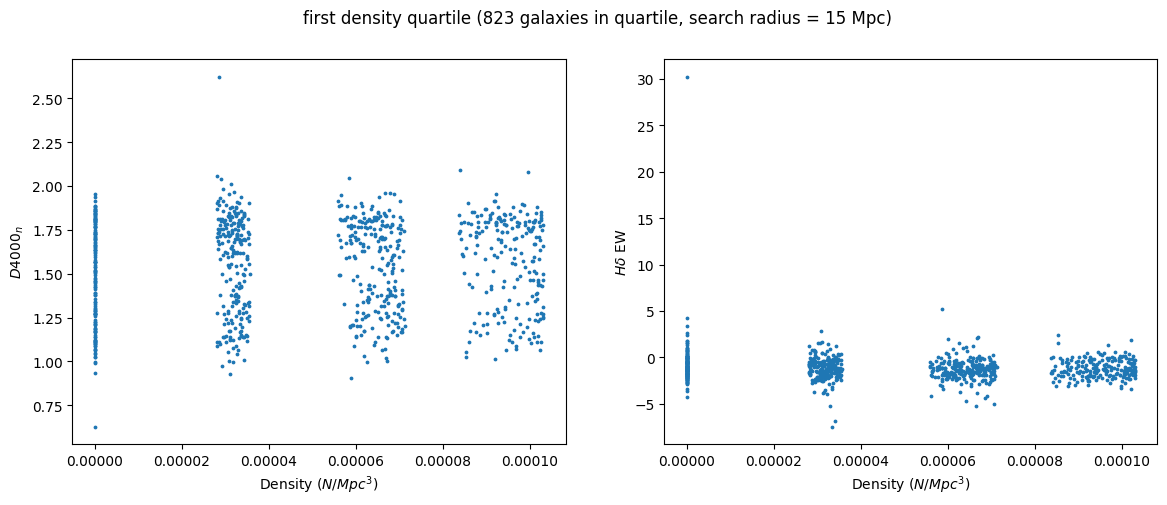

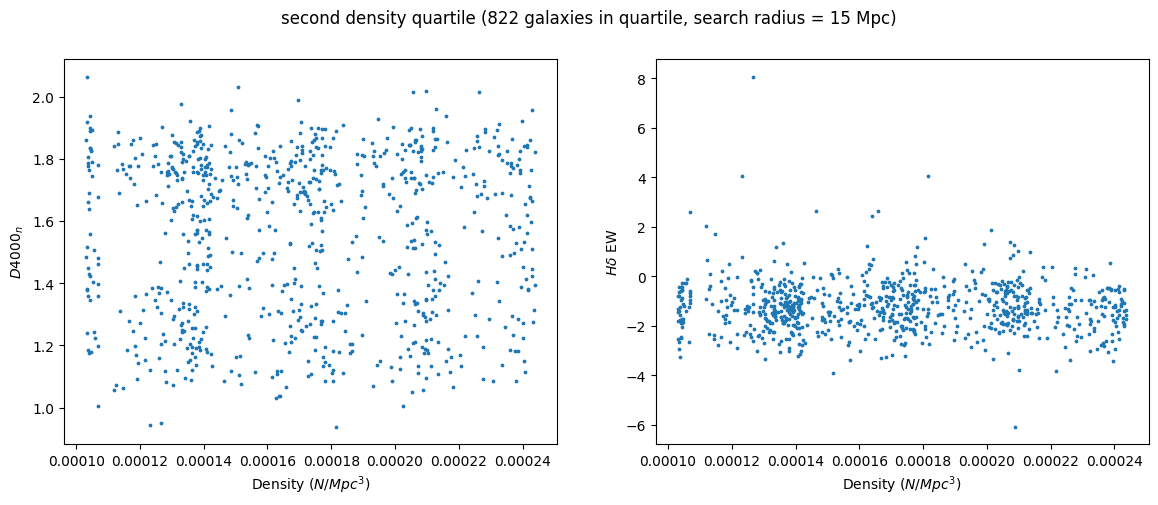

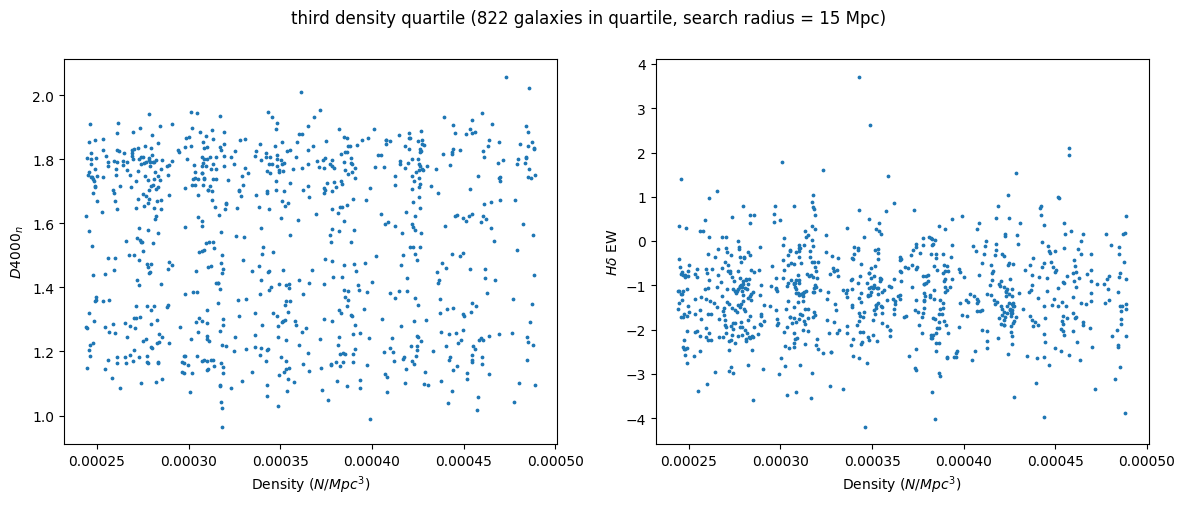

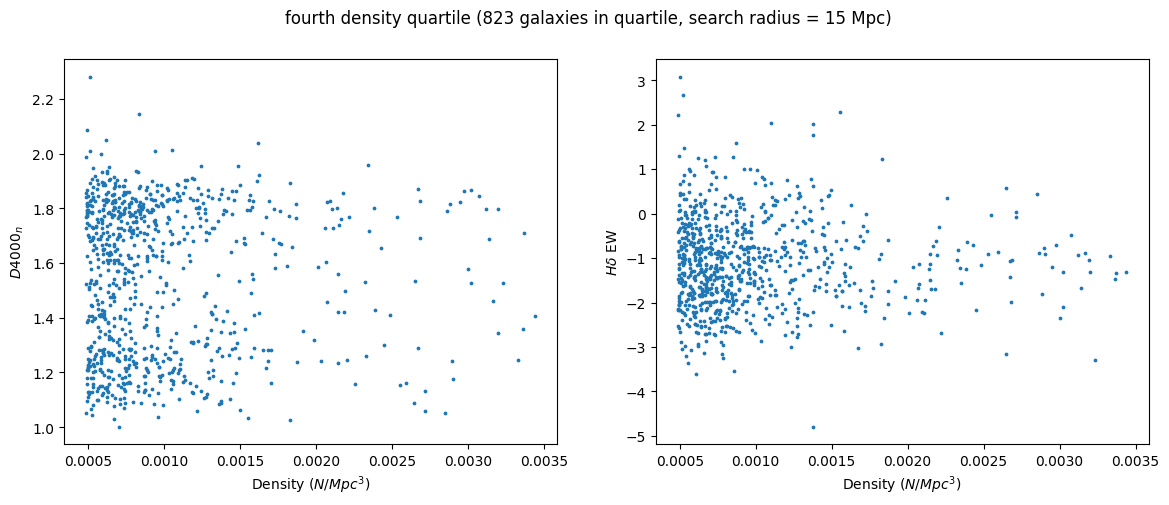

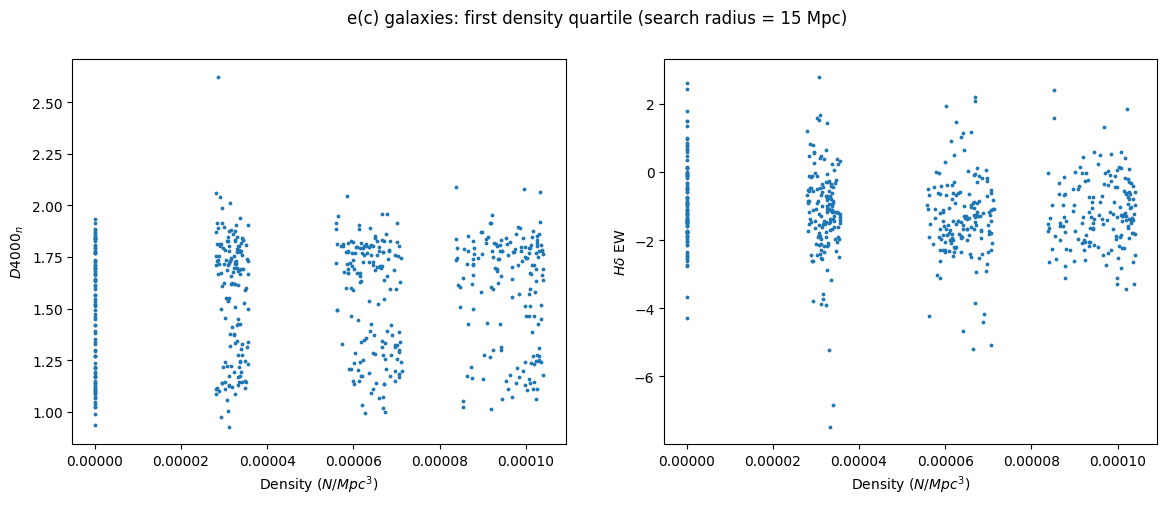

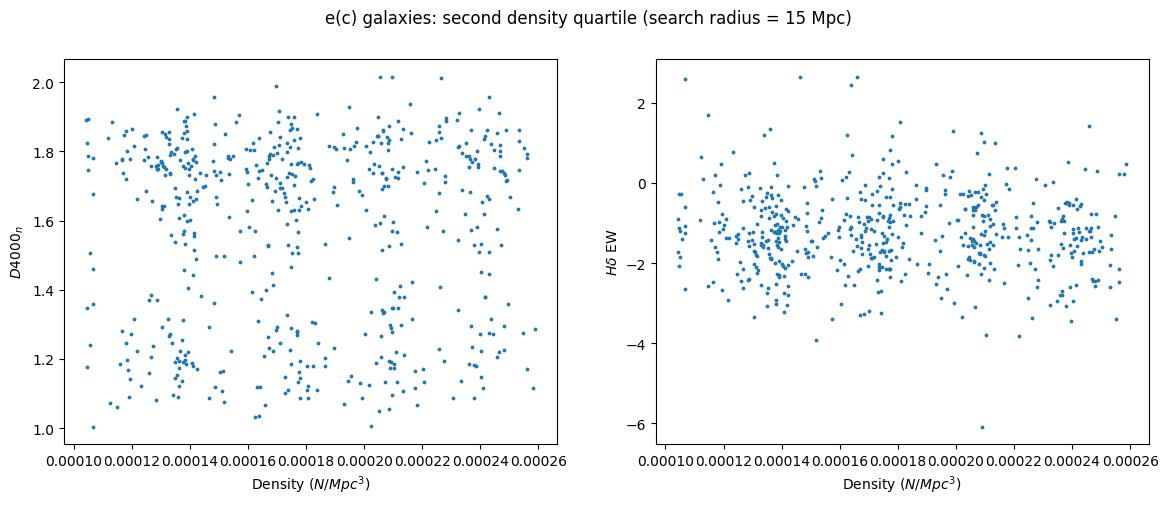

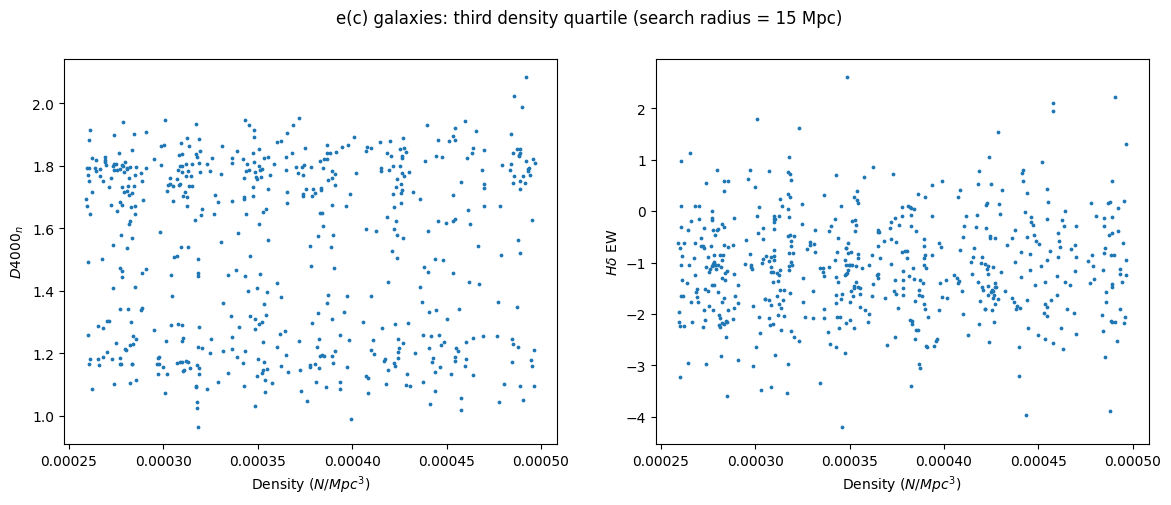

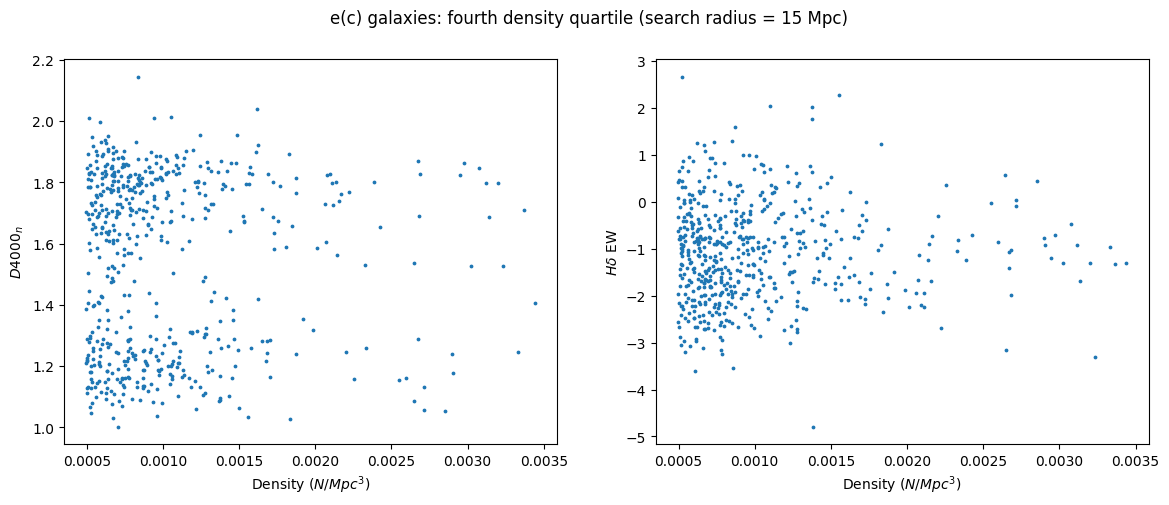

In [63]:
def plot_by_bin(dict_key, result, radius_index):
    radii = [2, 5, 10, 15]
    quartile_bins = bin_environment_by_quartile(dict_key, result, radius_index)
    for quartile, data in quartile_bins.items():
        if data['n'] == 0:
            continue
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
        n = data['n']
        mean = data['mean']
        median = data['median']
        std = data['std']
        mean_stderr = data['mean stderr']
        D4000n_vals = data['D4000n_vals']
        h_delta_vals= data['h_delta_vals']
        density_vals= data['density_vals']

        ax1.scatter(density_vals, D4000n_vals, s=3)
        ax1.set_xlabel(r'Density ($N/Mpc^3$)')
        ax1.set_ylabel(r'$D4000_n$')

        ax2.scatter(density_vals, h_delta_vals, s=3)
        ax2.set_xlabel(r'Density ($N/Mpc^3$)')
        ax2.set_ylabel(r'$H\delta$ EW')
        fig.suptitle(f'{quartile} density quartile ({n} galaxies in quartile, search radius = {radii[radius_index]} Mpc)')
        plt.show()

def plot_by_class_and_bin(dict_key, type_key, result, radius_index):
    radii = [2, 5, 10, 15]
    by_class_quartile_bins = bin_type_by_environment_quartile(dict_key, type_key, result, radius_index)
    for quartile, data in by_class_quartile_bins.items():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
        n = data['n']
        mean = data['mean']
        median = data['median']
        std = data['std']
        mean_stderr = data['mean stderr']
        D4000n_vals = data['D4000n_vals']
        h_delta_vals= data['h_delta_vals']
        density_vals= data['density_vals']

        ax1.scatter(density_vals, D4000n_vals, s=3)
        ax1.set_xlabel(r'Density ($N/Mpc^3$)')
        ax1.set_ylabel(r'$D4000_n$')

        ax2.scatter(density_vals, h_delta_vals, s=3)
        ax2.set_xlabel(r'Density ($N/Mpc^3$)')
        ax2.set_ylabel(r'$H\delta$ EW')
        fig.suptitle(f'{type_key} galaxies: {quartile} density quartile (search radius = {radii[radius_index]} Mpc)')
        plt.show()


plot_by_bin('class_dict', result, 3)
plot_by_class_and_bin('class_dict', 'e(c)', result, 3)

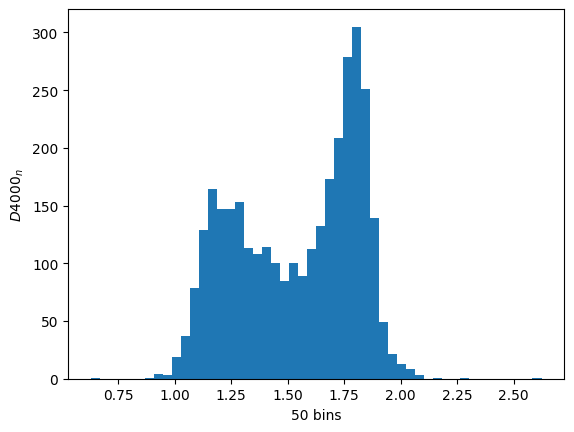

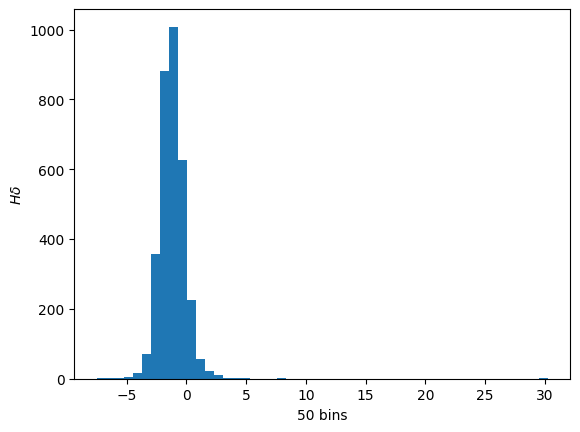

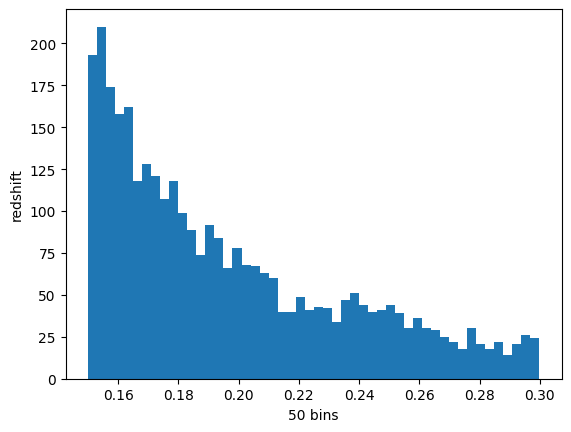

3290 galaxies counted, 34.20% or 1710 rejected.


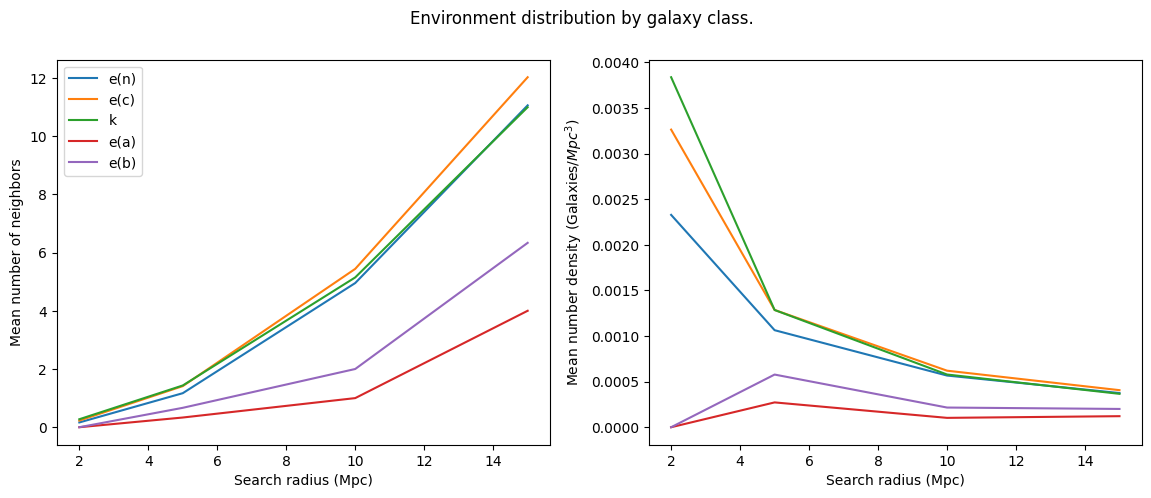

In [53]:
def plot_env_stats_by_type(dict_key, result):
    """
    Return a dictionary with the mean, min, and max for the number of neighbors and number density of each search radius for each galaxy class, 
    as well as the percentage of galaxies that were rejected by quality cuts.
    """
    radii=[2, 5, 10, 15]
    class_or_shape_dict = result[dict_key]
    total_counted = []
    total_rejected = []
    values_dict = {}
    for galaxy_type, data in class_or_shape_dict.items():
        num_counted_by_class = len(class_or_shape_dict[galaxy_type])
        if '?' in galaxy_type or 'dontknow' in galaxy_type:
            total_rejected.append(num_counted_by_class)
            continue
        total_counted.append(num_counted_by_class)
        values_dict[galaxy_type] = {
        'num_counted': num_counted_by_class,
        'by_radius': []
    }

        for i, radius in enumerate(radii):
            nnb_vals = []
            dens_vals = []
            for galaxy in data:
                nnb = galaxy['n_neighbors']
                dens = galaxy['densities']
                nnb_vals.append(nnb[i])
                dens_vals.append(dens[i])

            nnb_vals = np.array(nnb_vals)
            dens_vals = np.array(dens_vals)

            nnb_mean  = nnb_vals.mean()
            nnb_min   = nnb_vals.min()
            nnb_max   = nnb_vals.max()
            nnb_std   = nnb_vals.std()
            dens_mean = dens_vals.mean()
            dens_min  = dens_vals.min()
            dens_max  = dens_vals.max()
            dens_std  = dens_vals.std()
            
            values_dict[galaxy_type]['by_radius'].append(
                {
                    'radius': radius,
                    'values': {
                        'nnb_mean': nnb_mean,
                        'nnb_min': nnb_min,
                        'nnb_max': nnb_max,
                        'nnb_std': nnb_std,
                        'dens_mean': dens_mean,
                        'dens_min': dens_min,
                        'dens_max': dens_max,
                        'dens_std': dens_std
                    }
                }
            )
    values_dict['_summary'] = {
        'total_counted': sum(total_counted),
        'total_rejected':sum(total_rejected)
    }
      
    total_counted = values_dict['_summary']['total_counted']
    total_rejected = values_dict['_summary']['total_rejected']
    print(f"{total_counted} galaxies counted, {(total_rejected/(total_rejected+total_counted))*100:.2f}% or {total_rejected} rejected.")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for galaxy_type, info in values_dict.items():
        if galaxy_type == '_summary':
            continue

        radii = []
        nnb_means = []
        dens_means = []
        nnb_stds = []
        dens_stds = []

        for entry in info['by_radius']:
            radii.append(entry['radius'])
            nnb_means.append(entry['values']['nnb_mean'])
            nnb_stds.append(entry['values']['nnb_std'])
            dens_means.append(entry['values']['dens_mean'])
            dens_stds.append(entry['values']['dens_std'])

        #ax1.plot(radii, nnb_means, marker='o', label=galaxy_class)
        ax1.plot(
            radii,
            nnb_means,
            label=galaxy_type
        )
        ax2.plot(
            radii, 
            dens_means, 
            label=galaxy_type
        )

    ax1.set_xlabel("Search radius (Mpc)")
    ax1.set_ylabel("Mean number of neighbors")
    #ax1.set_yscale('log')
    ax1.legend()

    ax2.set_xlabel("Search radius (Mpc)")
    ax2.set_ylabel(r"Mean number density (Galaxies/$Mpc^3$)")
    #ax2.set_yscale('log')
    fig.suptitle(f'Environment distribution by galaxy {dict_key[:-5]}.')

    plt.show()

def set_bin_num_and_plot(dict_key, result, bins=100):
    class_or_shape_dict = result[dict_key]
    D4000n_vals = []
    h_delta_vals = []
    z_vals = []
    for galaxy_type, data in class_or_shape_dict.items():
        # Exclude rejected_galaxies:
        if '?' in galaxy_type:
            continue
        for galaxy in data:
            D4000n_vals.append(galaxy['D4000n'])
            h_delta_vals.append(galaxy['h_delta_EW'])
            z_vals.append(galaxy['z'])
    
    plt.hist(D4000n_vals, bins=bins)
    plt.xlabel(f"{bins} bins")
    plt.ylabel(r"$D4000_n$")
    plt.show()

    plt.hist(h_delta_vals, bins=bins)
    plt.xlabel(f"{bins} bins")
    plt.ylabel(r"$H\delta$")
    plt.show()

    plt.hist(z_vals, bins=bins)
    plt.xlabel(f"{bins} bins")
    plt.ylabel(r"redshift")
    plt.show()
    
def plot_vs_density_all_radii(dict_key, result, radii=[2, 5, 10, 15]):
    class_or_shape_dict = result[dict_key]

    # one figure per dependent variable
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    for i, r in enumerate(radii):
        dens_vals    = []
        D4000n_vals  = []
        h_delta_vals = []
        z_vals       = []

        for galaxy_type, data in class_or_shape_dict.items():
            if '?' in galaxy_type:
                continue

            for galaxy in data:
                dens_vals.append(galaxy['densities'][i])
                D4000n_vals.append(galaxy['D4000n'])
                h_delta_vals.append(galaxy['h_delta_EW'])
                z_vals.append(galaxy['z'])

        dens_vals    = np.asarray(dens_vals)
        D4000n_vals  = np.asarray(D4000n_vals)
        h_delta_vals = np.asarray(h_delta_vals)
        z_vals       = np.asarray(z_vals)

        ax1.scatter(dens_vals, D4000n_vals, s=3, alpha=0.5, label=f"{r} Mpc")
        ax2.scatter(dens_vals, h_delta_vals, s=3, alpha=0.5, label=f"{r} Mpc")
        ax3.scatter(dens_vals, z_vals, s=3, alpha=0.5, label=f"{r} Mpc")

    ax1.set_xlabel(r"Number density ($N/\mathrm{Mpc}^3$)")
    ax1.set_ylabel(r"$D4000_n$")
    ax1.legend()

    ax2.set_xlabel(r"Number density ($N/\mathrm{Mpc}^3$)")
    ax2.set_ylabel(r"$H\delta$")
    ax2.legend()

    ax3.set_xlabel(r"Number density ($N/\mathrm{Mpc}^3$)")
    ax3.set_ylabel("redshift")
    ax3.legend()

    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()

    plt.show()

#plot_vs_density_all_radii('class_dict', result, radii=[15])
set_bin_num_and_plot('class_dict', result, bins=50)
plot_env_stats_by_type('class_dict', result)

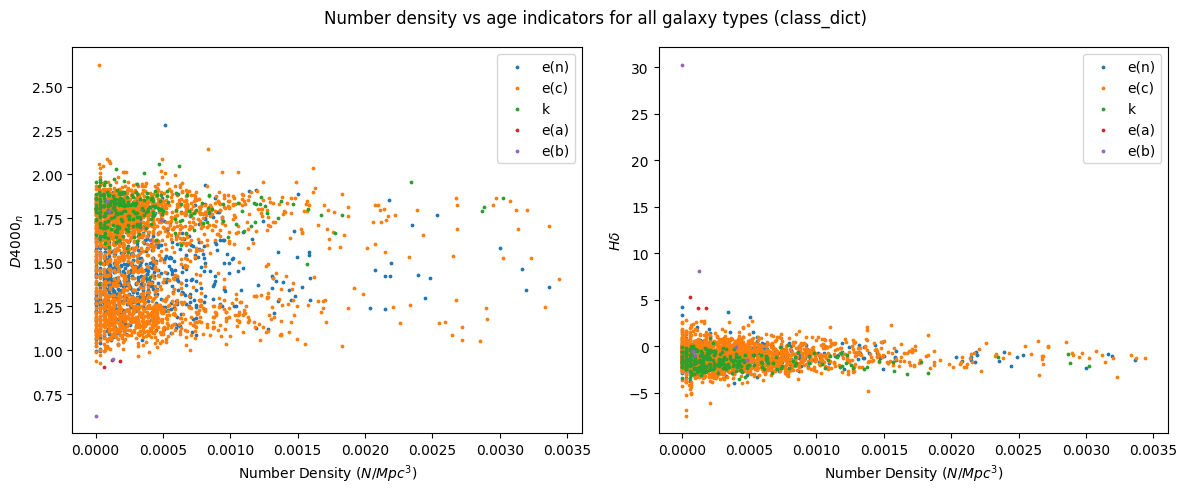

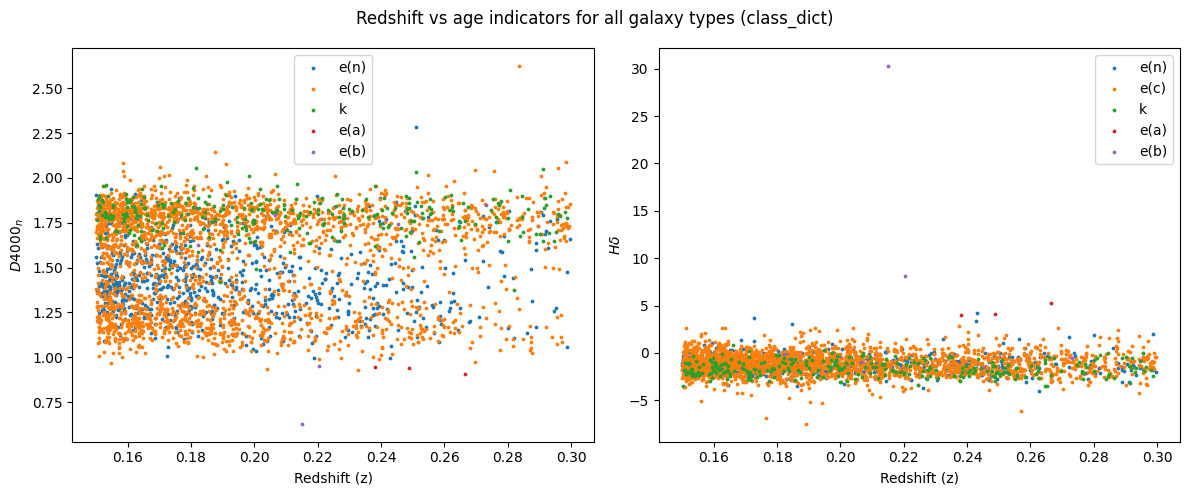

In [ ]:
def plot_age_indicators_and_num_density_for_all(dict_key, result, radius_index=0):
    """
    Plot all galaxy types on a single figure for a given search radius.
    radius_index: index in densities list (0 = 2 Mpc, 1 = 5 Mpc, 2 = 10 Mpc, 3 = 15 Mpc.)
    """
    class_or_shape_dict = result[dict_key]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=False)
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=False)
    
    for galaxy_type, data in class_or_shape_dict.items():
        if '?' in galaxy_type or 'dontknow' in galaxy_type:
            continue

        # Lists for this galaxy type
        D4000n_vals  = []
        h_delta_vals = []
        dens_vals    = []
        z_vals       = []

        for galaxy in data:
            dens_vals.append(galaxy['densities'][radius_index])
            D4000n_vals.append(galaxy['D4000n'])
            h_delta_vals.append(galaxy['h_delta_EW'])
            z_vals.append(galaxy['z'])

        # Convert to arrays
        dens_vals = np.array(dens_vals)
        D4000n_vals = np.array(D4000n_vals)
        h_delta_vals = np.array(h_delta_vals)
        

        # Plot
        ax1.scatter(dens_vals, D4000n_vals, s=3, label=galaxy_type)
        ax2.scatter(dens_vals, h_delta_vals, s=3, label=galaxy_type)

        ax3.scatter(z_vals, D4000n_vals, s=3, label=galaxy_type)
        ax4.scatter(z_vals, h_delta_vals, s=3, label=galaxy_type)

    ax1.set_ylabel(r'$D4000_n$')
    ax1.set_xlabel(r'Number Density ($N/Mpc^3$)')
    ax1.legend()
    
    ax2.set_ylabel(r'$H\delta$')
    ax2.set_xlabel(r'Number Density ($N/Mpc^3$)')
    ax2.legend()
    
    fig.suptitle(f'Number density vs age indicators for all galaxy types ({dict_key})')
    fig.tight_layout()

    ax3.set_ylabel(r'$D4000_n$')
    ax3.set_xlabel(r'Redshift (z)')
    ax3.legend()
    
    ax4.set_ylabel(r'$H\delta$')
    ax4.set_xlabel(r'Redshift (z)')
    ax4.legend()
    
    fig2.suptitle(f'Redshift vs age indicators for all galaxy types ({dict_key})')
    fig2.tight_layout()
    plt.show()

plot_age_indicators_and_num_density_for_all('class_dict', result, 3)